In [ ]:
#Libraries
library(caret)
library(keras)
use_condaenv("r-tensorflow")

# Exploration of Neural Networks

We first prepare our training data, note that we remove all highly correlated predictors as it has prooved to be useful. We used a cutoff value of 0.7 as papers suggest that a correlation coefficient higher than 0.7 means that predictors are highly correlated.

In [15]:
train <- read.csv(file = '../../Data/training_data.csv')
train <- subset(train,select = -SWEETORSOUR)
train$Intensity <- as.numeric(train$Intensity)
Y <- train$VALENCE.PLEASANTNESS
train <- subset(train,select = -VALENCE.PLEASANTNESS)
train.Z <- subset(train,select = -nearZeroVar(train))
correlation <- cor(train.Z)
id <- sort(findCorrelation(correlation, cutoff=0.7))
data.unC <- train.Z[,-id]
X <- as.matrix(data.unC)

Fitting a small, one-layer neural network to get a feeling for how well a neural network works.

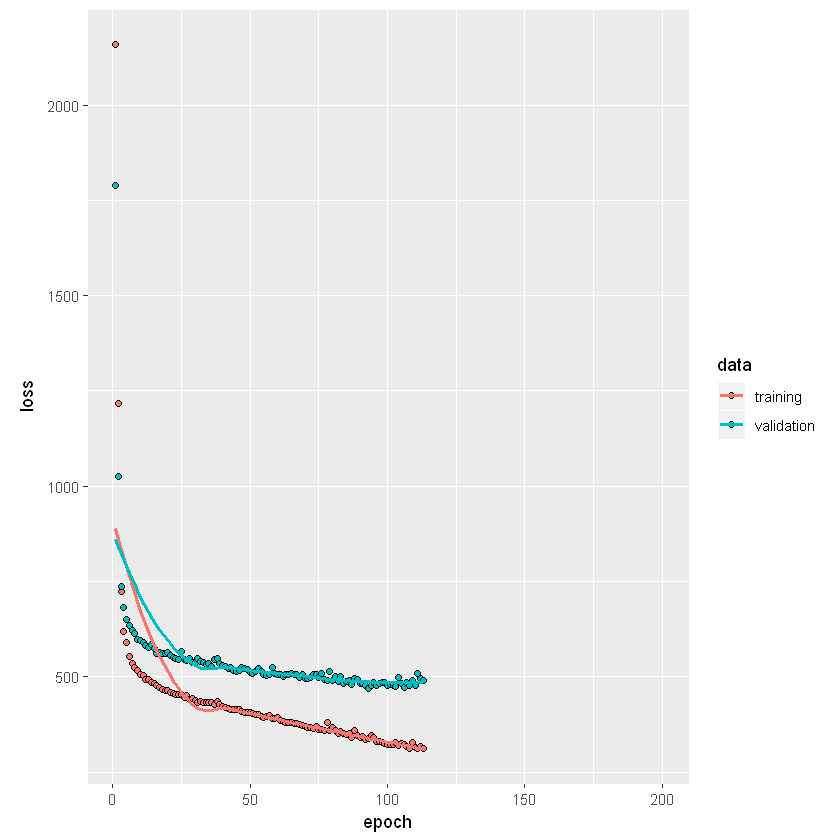

In [103]:
nn <- keras_model_sequential()

nn %>%
 layer_dense(units = 50,  activation = 'relu', kernel_initializer = "he_normal", input_shape = 196)  %>%
 layer_dense(units = 1,activation = 'linear')

nn %>% compile(
  loss = 'mse',
  optimizer = 'adam'
)

history <- nn %>% fit(
  (X), Y, 
  epochs = 200,
  validation_split = 0.5,
  callbacks = callback_early_stopping(monitor = "val_loss", patience = 20)
)
plot(history)

As we can see, the result is very average. We are now going to appropriately scale the data before fitting other neural networks.

In [104]:
#Libraries
library(caret)
library(keras)
library(MASS)
library(ggfortify)
use_condaenv("r-tensorflow")

In [6]:
train <- read.csv(file = '../../Data/training_data.csv')
train <- subset(train,select = -SWEETORSOUR)
train$Intensity <- as.numeric(train$Intensity)
train.Z <- subset(train,select = -nearZeroVar(train))
correlation <- cor(train.Z)
id <- sort(findCorrelation(correlation, cutoff=0.5))
data.unC <- train.Z[,-id]

#Splitting the data into a training and a validation set to simulate a test set
idx.train <- sample(nrow(data.unC), nrow(data.unC)*0.6)
Y <- train[idx.train,]$VALENCE.PLEASANTNESS
y.valid <- train[-idx.train,]$VALENCE.PLEASANTNESS
data.unC <- subset(data.unC,select = -VALENCE.PLEASANTNESS)
X <- data.unC[idx.train,]
X <- as.matrix(X)
x.valid <- data.unC[-idx.train,]
x.valid <- as.matrix(x.valid)

In [7]:
#Scaling methods
get.scale <- function(scaled) {
    if ("scaled:center" %in% names(attributes(scaled))) {
        center <- attr(scaled, "scaled:center")
    } else {
        center <- rep(0, ncol(scaled))
    }
    if ("scaled:scale" %in% names(attributes(scaled))) {
        list(center, attr(scaled, "scaled:scale"))
    } else {
        list(center, rep(1., length(center)))
    }
}
x.scale <- function(x, scaled) {
    s <- get.scale(scaled)
    centered <- sweep(x, 2, s[[1]])
    sweep(centered, 2, s[[2]], FUN = "/")
}
y.scale <- function(y, scaled) {
    s <- get.scale(scaled)
    (y - s[[1]])/s[[2]]
}
y.unscale <- function(y, scaled) {
    s <- get.scale(scaled)
    y * s[[2]] + s[[1]]
}

In [12]:
x.scaled <- scale(X,center = T, scale = T)
y.scaled <- scale(Y,center = T, scale = T)
x.valid.scaled <- x.scale(x.valid,x.scaled)
y.valid.scaled <- y.scale(y.valid,y.scaled)


#A function to test hyper parameters combinations
Neural_testing <- function(a = c(10,30,100),b = c(10,30,100), regul = c(0.1,0.01), drop = 0.6)){
    output <- c(1,1,1,1,100)
    for(i in a){
        for(j in b){
            for(z in regul){
                for(c in drop){
                    nn <- keras_model_sequential()

                    nn %>%
                     layer_dense(i,kernel_regularizer = regularizer_l2(l = z), activation = "relu", input_shape = c(dim(X)[2])) %>%
                     layer_dropout(rate = c) %>%
                     layer_dense(j, kernel_regularizer = regularizer_l2(l = z), activation = "relu") %>%
                     layer_dropout(rate = c) %>%
                     layer_dense(1, activation = "linear")

                    nn %>% compile(
                      loss = 'mse',
                      optimizer = 'adam'
                    )

                    history <- nn %>% fit(
                      (x.scaled), y.scaled, 
                      epochs = 1000,
                      validation_split = 0.5,
                      callbacks = callback_early_stopping(monitor = "val_loss", patience = 50)
                    )

                    nn.pred <- predict(nn, x.valid.scaled)
                    cat("Layer 1: ", i, "Layer 2: ", j, "error: ", sqrt(mean((y.unscale(nn.pred, y.scaled) - y.valid)^2)), "\n")
                    temp <- c(i,j,z,c,sqrt(mean((y.unscale(nn.pred, y.scaled) - y.valid)^2)))
                    if(temp[5]<output[5]){
                        output <- temp
                    }
                }
            }
        }
    }
    output
}

In [13]:
Neural_testing()

Layer 1:  10 Layer 2:  10 error:  22.41182 
Layer 1:  10 Layer 2:  10 error:  22.02303 
Layer 1:  10 Layer 2:  10 error:  23.60649 
Layer 1:  10 Layer 2:  10 error:  22.45232 
Layer 1:  10 Layer 2:  30 error:  23.1173 
Layer 1:  10 Layer 2:  30 error:  21.71314 
Layer 1:  10 Layer 2:  30 error:  23.16781 
Layer 1:  10 Layer 2:  30 error:  22.2653 
Layer 1:  10 Layer 2:  100 error:  23.21534 
Layer 1:  10 Layer 2:  100 error:  21.77309 
Layer 1:  10 Layer 2:  100 error:  23.24821 
Layer 1:  10 Layer 2:  100 error:  21.80139 
Layer 1:  30 Layer 2:  10 error:  22.92885 
Layer 1:  30 Layer 2:  10 error:  21.74964 
Layer 1:  30 Layer 2:  10 error:  23.57267 
Layer 1:  30 Layer 2:  10 error:  21.74489 
Layer 1:  30 Layer 2:  30 error:  22.59521 
Layer 1:  30 Layer 2:  30 error:  22.00372 
Layer 1:  30 Layer 2:  30 error:  24.16335 
Layer 1:  30 Layer 2:  30 error:  22.69851 
Layer 1:  30 Layer 2:  100 error:  23.14448 
Layer 1:  30 Layer 2:  100 error:  22.63977 
Layer 1:  30 Layer 2:  100 e

[1] 10.00000 30.00000  0.10000  0.60000 21.71314

From this testing run we conclude that the best hyperparameters would be a neural network with 2 hidden layers of 10 and 30 neurons, both of which are l2 regularized with a value of 0.1 and have a 0.6 (60%!!) dropout rate.  As expected the network must be tightly regularized to avoid overfitting.

In [ ]:
#results <- predict(nn, boston.x.scale(x.testa, boston.train.x.prep))
#results <- boston.y.unscale(results,boston.train.y.prep)
#id <- 1:68
#temps <- data.frame(results)
#final.data <- data.frame(Id = id, VALENCE.PLEASANTNESS = temps$results)
#write_csv(final.data, "../../Submission/NNopti.csv", row.names=FALSE)